<a href="https://colab.research.google.com/github/diipperss/Data-Analytics-SC1015-Project/blob/main/home.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## SC4020 Natural Language Processing Assignment

Our Team Group 27 Consist of the following members: (Please write ur full name)
- Tan Chuan You
- Tan Jun Yan Xavier
- Tan Jing Yi
- Divya Gupta
- Edmund

### Step 0 Dataset Preparation
We will be using the TREC question dataset introduced in https://cogcomp.seas.upenn.edu/
Data/QA/QC/, a collection of questions designed to be classified into a small set of categories. To
load this dataset, you need to install the “torchtext” library via pip install torchtext==0.4.0.
Note that version 0.4.0 needs to be used to avoid inconsistencies

In [ ]:
from torchtext import data, datasets

# For tokenization
TEXT = data.Field(tokenize = 'spacy',
                  tokenizer_language = 'en_core_web_sm',
                  include_lengths = True)

# For multi - class classification labels
LABEL = data.LabelField()

# Load the TREC dataset
train_data, test_data = datasets.TREC.splits(TEXT,
                                             LABEL,
                                             fine_grained = False)


In [ ]:
for i in range(5):
    print(f"Example {i+1}:")
    print(vars(train_data.examples[i]))
    print()

Example 1:
{'text': ['How', 'did', 'serfdom', 'develop', 'in', 'and', 'then', 'leave', 'Russia', '?'], 'label': 'DESC'}

Example 2:
{'text': ['What', 'films', 'featured', 'the', 'character', 'Popeye', 'Doyle', '?'], 'label': 'ENTY'}

Example 3:
{'text': ['How', 'can', 'I', 'find', 'a', 'list', 'of', 'celebrities', "'", 'real', 'names', '?'], 'label': 'DESC'}

Example 4:
{'text': ['What', 'fowl', 'grabs', 'the', 'spotlight', 'after', 'the', 'Chinese', 'Year', 'of', 'the', 'Monkey', '?'], 'label': 'ENTY'}

Example 5:
{'text': ['What', 'is', 'the', 'full', 'form', 'of', '.com', '?'], 'label': 'ABBR'}



## Step 1 Preparing Work Embeddings



#### We decide to use Word2Vec due to the nature of TREC dataset.
#### Yall decide this one make sense anot
TREC Training only consist of 5000 sentences with short sentences since we are classifying short, complete questions rather than long passages the dataset contains limited contextual information.
Word2Vec tend to perform better in capturing local syntatic and semantic relationships while GloVe tends to perform in Global semantic. In our case where we are trying to classify questions. Using Word2Vec helps to capture local semantics forming a stronger associations between keywords and the classes given.

#### Question 1
What is the size of the vocabulary formed from your training data according to your tokenization method?  <br>
- the size of vocab in text of training dataset is 9330. The size of vocab in Label is 6 as there are 6 unique labels.

In [ ]:
# Question 1 What is the size of the vocabulary formed from your training data according to your tokenization method
TEXT.build_vocab(train_data)
LABEL.build_vocab(train_data)
print("Vocabulary size (Text) :", len(TEXT.vocab))
print("Vocabulary size (Label):", len(LABEL.vocab))

Vocabulary size (Text) : 9330
Vocabulary size (Label): 6


#### Question 2
We use *OOV* (Out of Vocabulary) to refer to words appeared in the training data but not in the Word2vec/Glove dictionary. How many OOV words exists in your training data? What is the number of OOV words for each topic category<br>
- Number of OOV words is 496
- Number of OOV in ENTY:  187
- Number of OOV in HUM:  162
- Number of OOV in DESC:  140
- Number of OOV in NUM:  94
- Number of OOV in LOC:  92
- Number of OOV in ABBR:  21


In [23]:
import gensim.downloader as api

from gensim.models import KeyedVectors

# Question 2
# What is the number of OOV words for each topic category

# Load Pretrained word2vec got from https://code.google.com/archive/p/word2vec/
#pt_word2vec = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

# Load pretrained Google News Word2Vec embeddings
pt_word2vec = api.load("word2vec-google-news-300")  # ~1.5GB

# Get the set of unique words from our training and word2vec dataset
train_vocablist = set(TEXT.vocab.stoi.keys())

w2v_vocablist = set(pt_word2vec.key_to_index.keys())

# Number of unique OOV words
OOV = train_vocablist - w2v_vocablist

# Check if labels are in the word2vec vocab
print(f" Labels not in word2vec vocab: {set(LABEL.vocab.stoi.keys())-w2v_vocablist}")

# Check if the labels are in text vocab
print(f" Labels not in training text vocab: {set(LABEL.vocab.stoi.keys())-train_vocablist}")

print(f"Number of OOV: {len(OOV)} " )



 Labels not in word2vec vocab: {'ENTY', 'ABBR'}
 Labels not in training text vocab: {'ENTY', 'LOC', 'HUM', 'DESC', 'NUM', 'ABBR'}
Number of OOV: 496 


In [24]:
# Question 2
# What is the number of OOV words for each topic category
category_OOV = {}

# Create a set for each category
for category in LABEL.vocab.stoi.keys():
    category_OOV[category] = set()

for example in train_data:
    category = example.label
    for word in example.text:
        if word not in w2v_vocablist:
            category_OOV[category].add(word)

for category, oovlist in category_OOV.items():
    print(f"Number of OOV in {category}:  {len(oovlist)}")


Number of OOV in ENTY:  187
Number of OOV in HUM:  162
Number of OOV in DESC:  140
Number of OOV in NUM:  94
Number of OOV in LOC:  92
Number of OOV in ABBR:  21


In [25]:
numeric_oov = []
for word in OOV:
    # Check if integer
    if word.isdigit():
        numeric_oov.append(word)
    else:
        # Check if float
        try:
            float(word)
            numeric_oov.append(word)
        except ValueError:
            pass

print("Number of numeric OOVs:", len(numeric_oov))
print("Numeric OOV words:", numeric_oov)

Number of numeric OOVs: 228
Numeric OOV words: ['1847', '24', '1985', '26', '1879', '39', '1973', '900', '158', '22', '1899', '20', '387', '2010', '1980', '576', '1961', '1981', '2001', '1963', '15', '1967', '12', '197', '19', '168', '1994', '1857', '1669', '21', '1767', '1998', '139', '1912', '1978', '49', '1959', '2.5', '401', '1886', '142', '185', '528', '737', '1915', '172', '61', '1950', '9971', '84', '1881', '1988', '1925', '1943', '2112', '327', '2000', '28', '1932', '1974', '173', '13', '755', '126', '1922', '1946', '31', '1966', '1919', '80', '1933', '103', '1863', '1939', '1927', '14', '239', '219', '1928', '740', '90', '1957', '55', '72', '1976', '864', '137', '1990', '195', '1834', '1895', '16', '1996', '1797', '1955', '227', '007', '924', '1971', '1699', '1562', '732', '5.9', '37803', '985', '1830', '1866', '95', '11', '192', '1926', '46', '70', '100', '1931', '1948', '17', '1993', '1891', '1982', '1997', '1853', '47', '1898', '1999', '1952', '175', '18', '1649', '1953', '

#### Question 3
The existence of the OOV words is one of the well-known limitations of Word2vec (or Glove). Without using any transformer-based language models (e.g., BERT, GPT, T5), what do you think is the best strategy to mitigate such limitation? Implement your solution in your source code. Show the corresponding code snippet. <br>

In word2vec pretrain model trained from GoogleNews-vectors-negative300.bin. have a fixed vocabulary. As a result, some words in the training data may be unknown because they are not included in the pretrained dataset. These unknown words lack embeddings, which is a limitation of Word2vec/Glove since unlike transformer-based language models, word2vec requires every vector to have a corresponding vector representation. To mitigate such limitation our group propose a hybrid approach combining preprocessing, lemmatisation and random initialisation. <br>

Firsty I noticed that there are alot of occurence of numbers within the unknown OOVs hence decide to simplify them into NUM tag this is because we are currently working on the TREC data set and the numbers might not be considered as significant as long as categorise them as numerical.Secondly the OOV the unknown words are lemmatized and cross checked with the existing word2vec vocabulary. If it exists we will use pretrained lemmatized corresponding vector. For words that still do not match any known embedding. We will assign a random vector ensuring that every word has a representation for the upcoming tasks.


In [26]:
# Creating Embedding Matrix
import numpy as np
import spacy

# Using word2vec pretrained embedding , each word is represented by a 300-dimensional vector
spacy_model = spacy.load("en_core_web_sm")
embedding_dim = 300
embedding_matrix = np.zeros((len(TEXT.vocab),embedding_dim))

# Calculate the mean and standard deviation for word2vec pretrained so the randomly generated embedding can be done within the same scope
vectors = pt_word2vec.vectors
w2v_mean = np.mean(vectors)
w2v_std = np.std(vectors)

# Generate a <NUM> embedding for the numerical
numerical_embedding = np.random.normal(
                loc= w2v_mean,
                scale = w2v_std,
                size = embedding_dim)
counter = 0
for word, id in TEXT.vocab.stoi.items():
    # 1st Step Check if word is in word2vec.
    if word in w2v_vocablist:
        embedding_matrix[id] = pt_word2vec[word]
    # if not, apply lemmatization to the word and
    elif word.isdigit():
        embedding_matrix[id] = numerical_embedding
    else:
        # Lemmatize based on spacy en_core_web_sm model
        doc = spacy_model(word)
        lemma = doc[0].lemma_

        if lemma in w2v_vocablist:
            embedding_matrix[id] = pt_word2vec[lemma]
        else: # Finally randomly assign those that are not in vocab
            embedding_matrix[id] = np.random.normal(
                loc= w2v_mean,
                scale = w2v_std,
                size = embedding_dim)
            counter += 1

print(f"Number of OOV assigned with random vectors: {counter}")

Number of OOV assigned with random vectors: 264


#### Question 4
Select the 20 most frequent words from each topic category in the training set (removing stopwords if necessary). Retrieve their pretrained embeddings (from Word2Vec or GloVe).Project these embeddings into 2D space (using e.g., t-SNE or Principal Component Analysis).Plot the points in a scatter plot, color-coded by their topic category Attach your plot here. Analyze your findings. <br>



In [27]:
# For each category find the top 20 most frequent words
stopwords = spacy_model.Defaults.stop_words
top20_vocab = {}

for category in LABEL.vocab.stoi.keys():  # iterate over all labels
    word_freq = {}  # dictionary to count frequency
    for example in train_data.examples:
        if example.label == category:
            # ex.text is a list of tokens (TEXT field already tokenizes)
            tokens = []
            for token in example.text:
                token = token.lower()
                if token.isalpha() and token not in stopwords:  # filter alphabetic and non-stopwords
                    tokens.append(token)
            for t in tokens:
                if t in word_freq:
                    word_freq[t] += 1
                else:
                    word_freq[t] = 1
    # Sort by frequency and take top 20
    top_words = sorted(word_freq, key=word_freq.get, reverse=True)[:20]
    top20_vocab[category] = set(top_words)

# Print results
for category, words in top20_vocab.items():
    print(f"Category: {category} \n Top 20 words: {words}")

Category: ENTY 
 Top 20 words: {'color', 'fear', 'term', 'tv', 'book', 'world', 'movie', 'game', 'drink', 'sport', 'best', 'called', 'word', 'novel', 'play', 'kind', 'english', 'war', 'film', 'animal'}
Category: HUM 
 Top 20 words: {'won', 'known', 'star', 'invented', 'tv', 'character', 'baseball', 'world', 'famous', 'movie', 'company', 'actress', 'portrayed', 'said', 'new', 'team', 'wrote', 'president', 'actor', 'american'}
Category: DESC 
 Top 20 words: {'history', 'meaning', 'term', 'definition', 'come', 'mean', 'find', 'people', 'like', 'water', 'famous', 'causes', 'happened', 'work', 'word', 'difference', 'origin', 'school', 'makes', 't'}
Category: NUM 
 Top 20 words: {'earth', 'day', 'people', 'average', 'world', 'date', 'long', 'game', 'year', 'live', 'years', 'born', 'population', 'old', 'die', 'number', 'war', 'begin', 'american', 'cost'}
Category: LOC 
 Top 20 words: {'located', 'south', 'america', 'mountain', 'information', 'island', 'find', 'states', 'world', 'state', 'live

In [28]:
# Conver the tokens into embeddings based on word 2
top20_embedding = {}

for category, words in top20_vocab.items():
    embeddings = []
    for w in words:
        if w in TEXT.vocab.stoi:
            idx = TEXT.vocab.stoi[w]
            embeddings.append(embedding_matrix[idx])
        else:
            # Just in case got problem
            embeddings.append(np.random.normal(0, 0.1, embedding_matrix.shape[1]))
    top20_embedding[category] = np.array(embeddings)

#
for category, embs in top20_embedding.items():
    print(f"Category: {category}, embeddings shape: {embs.shape}")

Category: ENTY, embeddings shape: (20, 300)
Category: HUM, embeddings shape: (20, 300)
Category: DESC, embeddings shape: (20, 300)
Category: NUM, embeddings shape: (20, 300)
Category: LOC, embeddings shape: (20, 300)
Category: ABBR, embeddings shape: (20, 300)


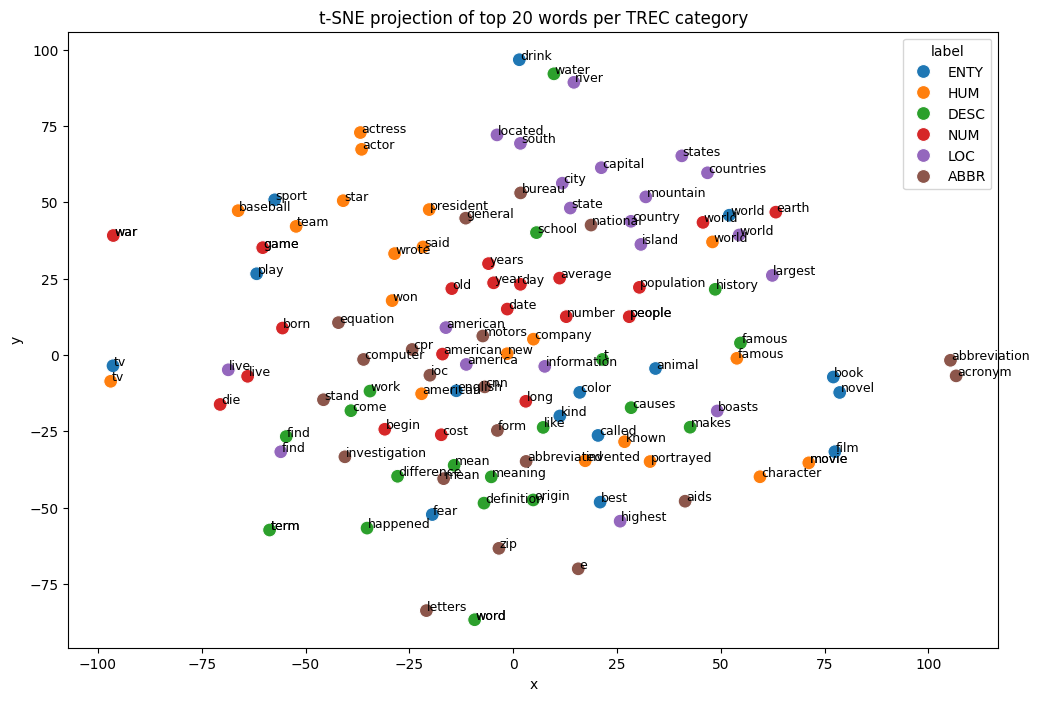

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

# Plot t-SNE for each all words and each catergory is coloured

X = []
category_list = []
embedding_list = []


for category, embs in top20_embedding.items():
    for i, vec in enumerate(embs):
        X.append(vec)
        category_list.append(category)
        # Convert set to list to get word text
        word = list(top20_vocab[category])[i]
        embedding_list.append(word)

X = np.array(X)

# Step 2: Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=15)
X_2d = tsne.fit_transform(X)

# Step 3: Prepare DataFrame
df_plot = pd.DataFrame({
    'x': X_2d[:,0],
    'y': X_2d[:,1],
    'label': category_list,
    'word': embedding_list
})

# Plot scatter to see relationship
plt.figure(figsize=(12,8))
sns.scatterplot(data=df_plot, x='x', y='y', hue='label', palette='tab10', s=100)

# Annotate words
for i, row in df_plot.iterrows():
    plt.text(row['x']+0.2, row['y']+0.2, row['word'], fontsize=9)

plt.title("t-SNE projection of top 20 words per TREC category")
plt.show()

Based on the t-SNE plot above of the top 20 most frequent words per category, we can observed that most categories forms distint cluster which shows how the embedings reflect the semantic relationship beteween the more frequent words and their respective classes.
- HUM category are distributed roughly along -50 <= Y <= 50
- DESC category are distributed and clustered at the right side of the graph
- NUM category are distributed at the centre of the graph
- LOC catrgory are distributed roughly along the right side of the graph
- ENTY are more widely spread throughout the graph which may be an issue

This clustering shows that word2vec embedding successfully capure semantic relationship between words which manage to gruup them accourding to catefory. While there are outliers we can generally see the trends discussed above. It also highlighted the weakness and some categories overlap each other and may require more processing during the model training phase to be more accurate in the classification

# Part 2. Model Training & Evaluation - RNN

Now with the pretrained word embeddings acquired from Part 1 and the dataset acquired from Part
0, you need to train a deep learning model for topic classification using the training set, conforming to these requirements:

*   Use the pretrained word embeddings from Part 1 as inputs, together with your implementation
in mitigating the influence of OOV words; make them learnable parameters during training
(they are updated).
*   Design a simple recurrent neural network (RNN), taking the input word embeddings, and
predicting a topic label for each sentence. To do that, you need to consider how to aggregate
the word representations to represent a sentence.


In [31]:
import torch
import torch.nn as nn

class RNNClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, embedding_matrix, n_layers=1, bidirectional=False, dropout=0.0):
        super().__init__()

        #Load pretrained embeddings from embedding_matrix in part 1
        self.embedding = nn.Embedding.from_pretrained(
            torch.FloatTensor(embedding_matrix),
            freeze=False  # ensures embeddings are (learnable)
        )

        # Handle OOV: add an <unk> token embedding that learns from scratch
        self.embedding.padding_idx = 0  # assuming index 0 = <pad>

        # Define vanilla RNN
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers=n_layers,
                          bidirectional=bidirectional, dropout=dropout, batch_first=False)

        # Fully connected layer for output
        self.fc = nn.Linear(hidden_dim * (2 if bidirectional else 1), output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text, text_lengths):
        #extract embedding
        embedded = self.dropout(self.embedding(text))  # [seq_len, batch, emb_dim]

        #handle padded embeddings
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.cpu(), enforce_sorted=False)

        #feed into RNN
        packed_output, hidden = self.rnn(packed_embedded)

        #extract final hidden state of RNN
        if self.rnn.bidirectional:
            #concatenate forward and backward hidden states
            hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        else:
            hidden = hidden[-1,:,:]

        output = self.fc(self.dropout(hidden))
        return output

Training & Validation

*   Use the validation set to gauge the performance of the model for each epoch during training.
You are required to use accuracy as the performance metric during validation and evaluation.
*   Use the mini-batch strategy during training. You may choose any preferred optimizer (e.g.,
SGD, Adagrad, Adam, RMSprop). Be careful when you choose your initial learning rate and
mini-batch size. (You should use the validation set to determine the optimal configuration.)
Train the model until the accuracy score on the validation set is not increasing for a few
epochs



In [38]:
def evaluate(model, iterator, criterion, device):
    #need to switch to evaluation mode so there is no dropout
    model.eval()
    epoch_loss, correct, total = 0, 0, 0

    #faster computation due to no gradient computation
    with torch.no_grad():
        for batch in iterator:
          text, text_lengths = batch.text
          labels = batch.label
          text, text_lengths, labels = text.to(device), text_lengths.to(device), labels.to(device)

          predictions = model(text, text_lengths)
          loss = criterion(predictions, labels)
          epoch_loss += loss.item()
          preds = torch.argmax(predictions, dim=1)
          correct += (preds == labels).sum().item()
          total += labels.size(0)

    #return average loss and accuracy (Average over all positions)
    return epoch_loss / len(iterator), correct / total


In [39]:
import torch.optim as optim

def train_model(model, train_iterator, valid_iterator, criterion, lr, num_epochs, patience, device):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    best_valid_acc = 0
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        #training mode enables dropout and updating of gradient
        model.train()
        train_loss, correct, total = 0, 0, 0

        #mini-batch training
        for batch in train_iterator:
          text, text_lengths = batch.text
          labels = batch.label
          text, text_lengths, labels = text.to(device), text_lengths.to(device), labels.to(device)

          optimizer.zero_grad()
          predictions = model(text, text_lengths)
          loss = criterion(predictions, labels)
          loss.backward()
          optimizer.step()

          train_loss += loss.item()
          preds = torch.argmax(predictions, dim=1)
          correct += (preds == labels).sum().item()
          total += labels.size(0)
        train_acc = correct / total
        valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

        print(f"Epoch {epoch+1}: Train Acc {train_acc:.3f}, Val Acc {valid_acc:.3f}")

        # Early stopping if validation accuracy stops improving
        if valid_acc > best_valid_acc:
            best_valid_acc = valid_acc
            epochs_no_improve = 0
            best_model = model.state_dict()
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print("Early stopping triggered.")
                break

    model.load_state_dict(best_model)
    return model

Run the training

In [40]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [41]:
# Split train_data into training and validation sets (80% train, 20% valid)
train_data, valid_data = train_data.split(split_ratio=0.8, random_state=np.random.seed(42))
print(f"Number of training examples: {len(train_data)}")
print(f"Number of validation examples: {len(valid_data)}")

Number of training examples: 3490
Number of validation examples: 872


In [42]:
#initialize model
model = RNNClassifier(
    vocab_size=len(TEXT.vocab),
    embedding_dim=300,
    hidden_dim=256,
    output_dim=len(LABEL.vocab),
    embedding_matrix=embedding_matrix,
    n_layers=1,
    bidirectional=False,
    dropout=0.5
)
model = model.to(device)

#initialize loss function as cross entropy loss
import torch.nn as nn
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

#create mini-batch iterators
from torchtext.data import BucketIterator

BATCH_SIZE = 64
train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size=BATCH_SIZE,
    sort_within_batch=True,
    sort_key=lambda x: len(x.text),
    device=device
)

#call the training function
LEARNING_RATE = 0.001
NUM_EPOCHS = 20
PATIENCE = 3

trained_model = train_model(
    model,
    train_iterator,
    valid_iterator,
    criterion,
    lr=LEARNING_RATE,
    num_epochs=NUM_EPOCHS,
    patience=PATIENCE,
    device=device
)


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Epoch 1: Train Acc 0.310, Val Acc 0.461
Epoch 2: Train Acc 0.551, Val Acc 0.710
Epoch 3: Train Acc 0.678, Val Acc 0.745
Epoch 4: Train Acc 0.780, Val Acc 0.701
Epoch 5: Train Acc 0.840, Val Acc 0.761
Epoch 6: Train Acc 0.861, Val Acc 0.721
Epoch 7: Train Acc 0.886, Val Acc 0.806
Epoch 8: Train Acc 0.951, Val Acc 0.800
Epoch 9: Train Acc 0.957, Val Acc 0.817
Epoch 10: Train Acc 0.969, Val Acc 0.821
Epoch 11: Train Acc 0.972, Val Acc 0.817
Epoch 12: Train Acc 0.977, Val Acc 0.791
Epoch 13: Train Acc 0.986, Val Acc 0.806
Early stopping triggered.


In [45]:
#evaluate on test data
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def test_model(model, test_iterator, device):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for text, text_lengths, labels in test_iterator:
            text, text_lengths, labels = text.to(device), text_lengths.to(device), labels.to(device)
            predictions = model(text, text_lengths)
            preds = torch.argmax(predictions, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print("Test Accuracy:", accuracy_score(all_labels, all_preds))
    print(classification_report(all_labels, all_preds))
    print("Confusion Matrix:\n", confusion_matrix(all_labels, all_preds))

The above is the baseline model which is the training of RNN without any explicit regularization.

# Regularization
*   Try different regularization techniques to mitigate overfitting.



In [ ]:
#Dropout
self.dropout = nn.Dropout(0.5)

In [46]:
# Dropout regularization
dropout = 0.5

model = RNNClassifier(
    vocab_size=len(TEXT.vocab),
    embedding_dim=300,
    hidden_dim=256,
    output_dim=len(LABEL.vocab),
    embedding_matrix=embedding_matrix,
    n_layers=1,
    bidirectional=False,
    dropout=dropout
)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for text, text_lengths, labels in train_iterator:
    text, text_lengths, labels = text.to(device), text_lengths.to(device), labels.to(device)
    optimizer.zero_grad()
    predictions = model(text, text_lengths)
    loss = criterion(predictions, labels)
    loss.backward()
    optimizer.step()

test_model(model, test_iterator, device)

ValueError: not enough values to unpack (expected 3, got 2)

In [ ]:
test_model(trained_model, test_iterator, device)

In [ ]:
#L1 Regularization
import torch.optim as optim

# L1 Regularization parameters
L1_lambda = 1e-5

optimizer = optim.Adam(model.parameters(), lr=0.001)  # No weight_decay here since L2 is separate

for text, text_lengths, labels in train_iterator:
    text, text_lengths, labels = text.to(device), text_lengths.to(device), labels.to(device)
    optimizer.zero_grad()

    predictions = model(text, text_lengths)
    loss = criterion(predictions, labels)

    # L1 penalty
    L1_norm = sum(p.abs().sum() for p in model.parameters())
    loss = loss + L1_lambda * L1_norm

    loss.backward()
    optimizer.step()

# Evaluate on test set
test_model(model, test_iterator, device)


In [ ]:
#L2 Regularization
# L2 regularization via weight decay
model = RNNClassifier(
    vocab_size=len(TEXT.vocab),
    embedding_dim=300,
    hidden_dim=256,
    output_dim=len(LABEL.vocab),
    embedding_matrix=embedding_matrix,
    n_layers=1,
    bidirectional=False,
    dropout=0.0  # No dropout
)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # L2 regularization

for text, text_lengths, labels in train_iterator:
    text, text_lengths, labels = text.to(device), text_lengths.to(device), labels.to(device)
    optimizer.zero_grad()
    predictions = model(text, text_lengths)
    loss = criterion(predictions, labels)
    loss.backward()
    optimizer.step()

test_model(model, test_iterator, device)


In [ ]:
# Gradient clipping
model = RNNClassifier(
    vocab_size=len(TEXT.vocab),
    embedding_dim=300,
    hidden_dim=256,
    output_dim=len(LABEL.vocab),
    embedding_matrix=embedding_matrix,
    n_layers=1,
    bidirectional=False,
    dropout=0.0  # No dropout
)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
max_norm = 1.0  # Clip gradients to this norm

for text, text_lengths, labels in train_iterator:
    text, text_lengths, labels = text.to(device), text_lengths.to(device), labels.to(device)
    optimizer.zero_grad()
    predictions = model(text, text_lengths)
    loss = criterion(predictions, labels)
    loss.backward()

    # Clip gradients
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)

    optimizer.step()

test_model(model, test_iterator, device)

Evaluate your trained model on the test dataset, observing the accuracy score

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def test_model(model, test_iterator, device):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for text, text_lengths, labels in test_iterator:
            text, text_lengths, labels = text.to(device), text_lengths.to(device), labels.to(device)
            predictions = model(text, text_lengths)
            preds = torch.argmax(predictions, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print("Test Accuracy:", accuracy_score(all_labels, all_preds))
    print(classification_report(all_labels, all_preds))
    print("Confusion Matrix:\n", confusion_matrix(all_labels, all_preds))